Remaining missing values:
 Age                            0
Gender                         0
Parental_Education             0
Family_Income                  0
Previous_Grades                0
Attendance                     0
Class_Participation            0
Study_Hours                    0
Major                          0
School_Type                    0
Financial_Status               0
Parental_Involvement           0
Educational_Resources          0
Motivation                     0
Self_Esteem                    0
Stress_Levels                  0
School_Environment             0
Professor_Quality              0
Class_Size                     0
Extracurricular_Activities     0
Sleep_Patterns                 0
Nutrition                      0
Physical_Activity              0
Screen_Time                    0
Educational_Tech_Use           0
Peer_Group                     0
Bullying                       0
Study_Space                    0
Learning_Style                 0
Tutoring        

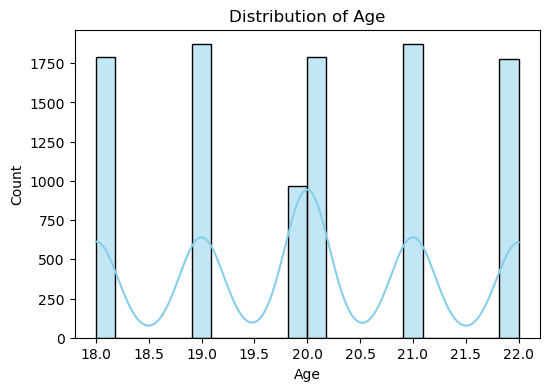

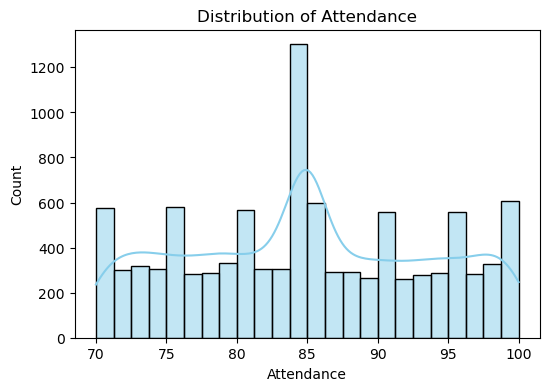

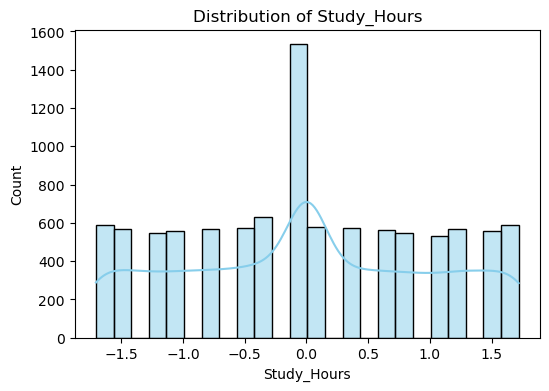

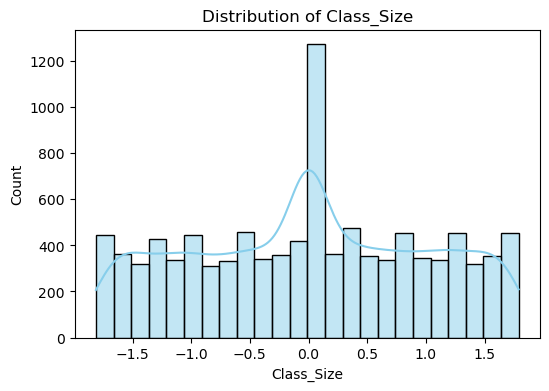

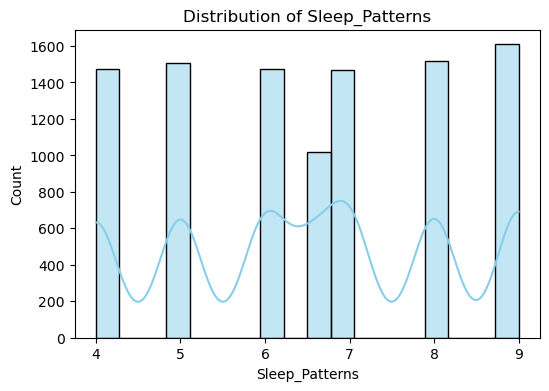

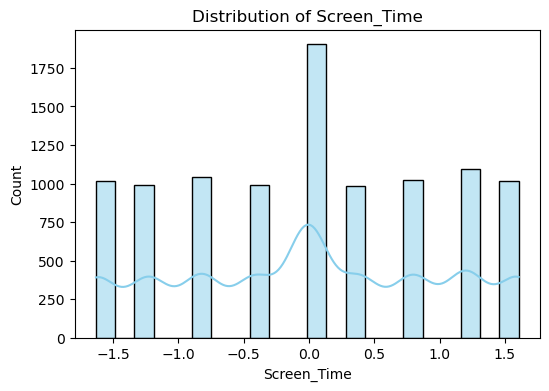

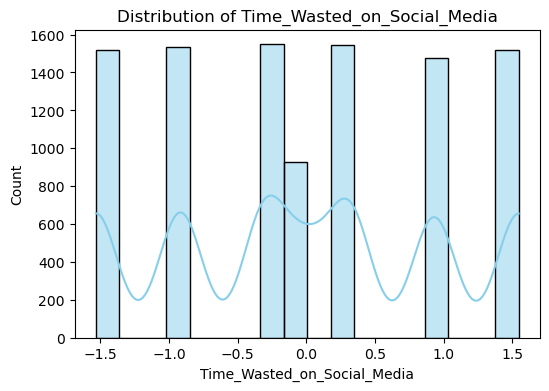

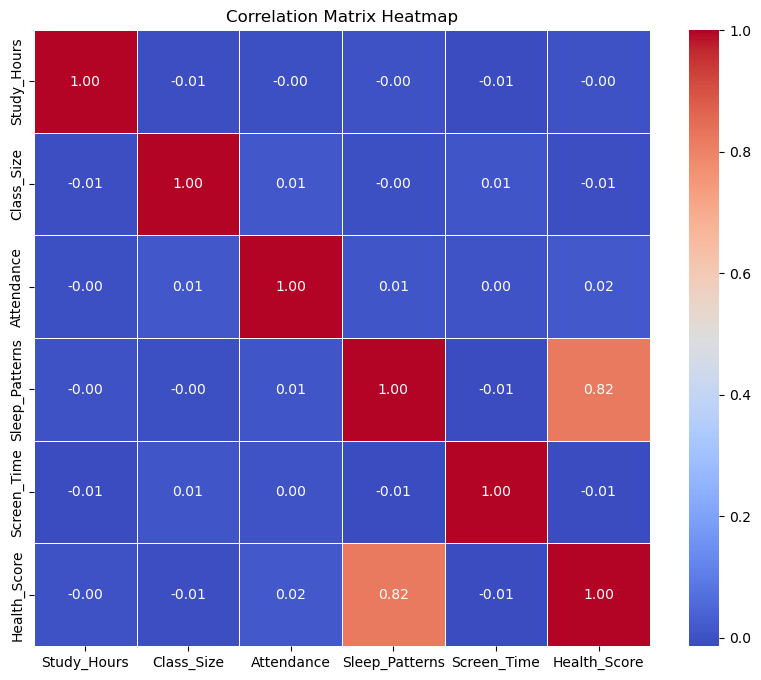

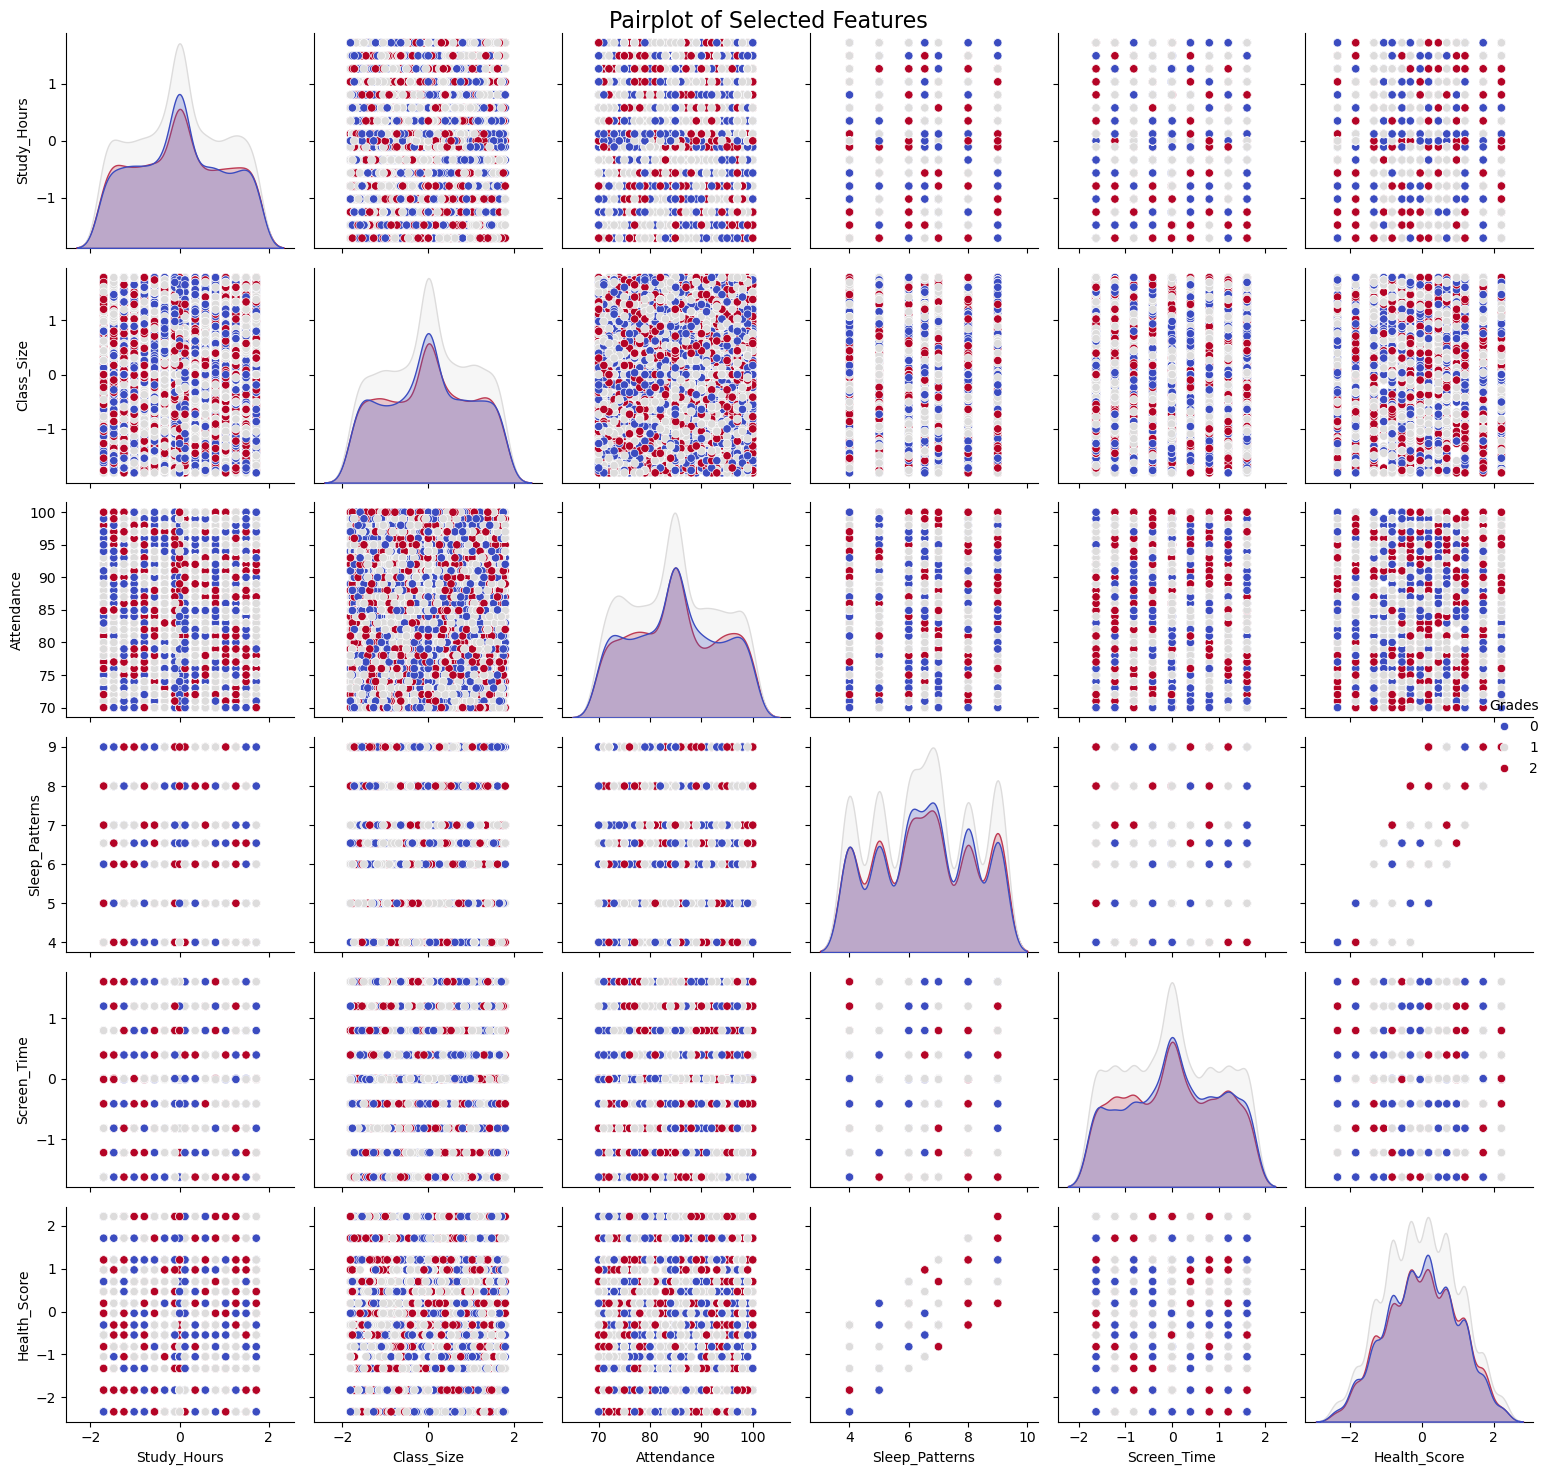

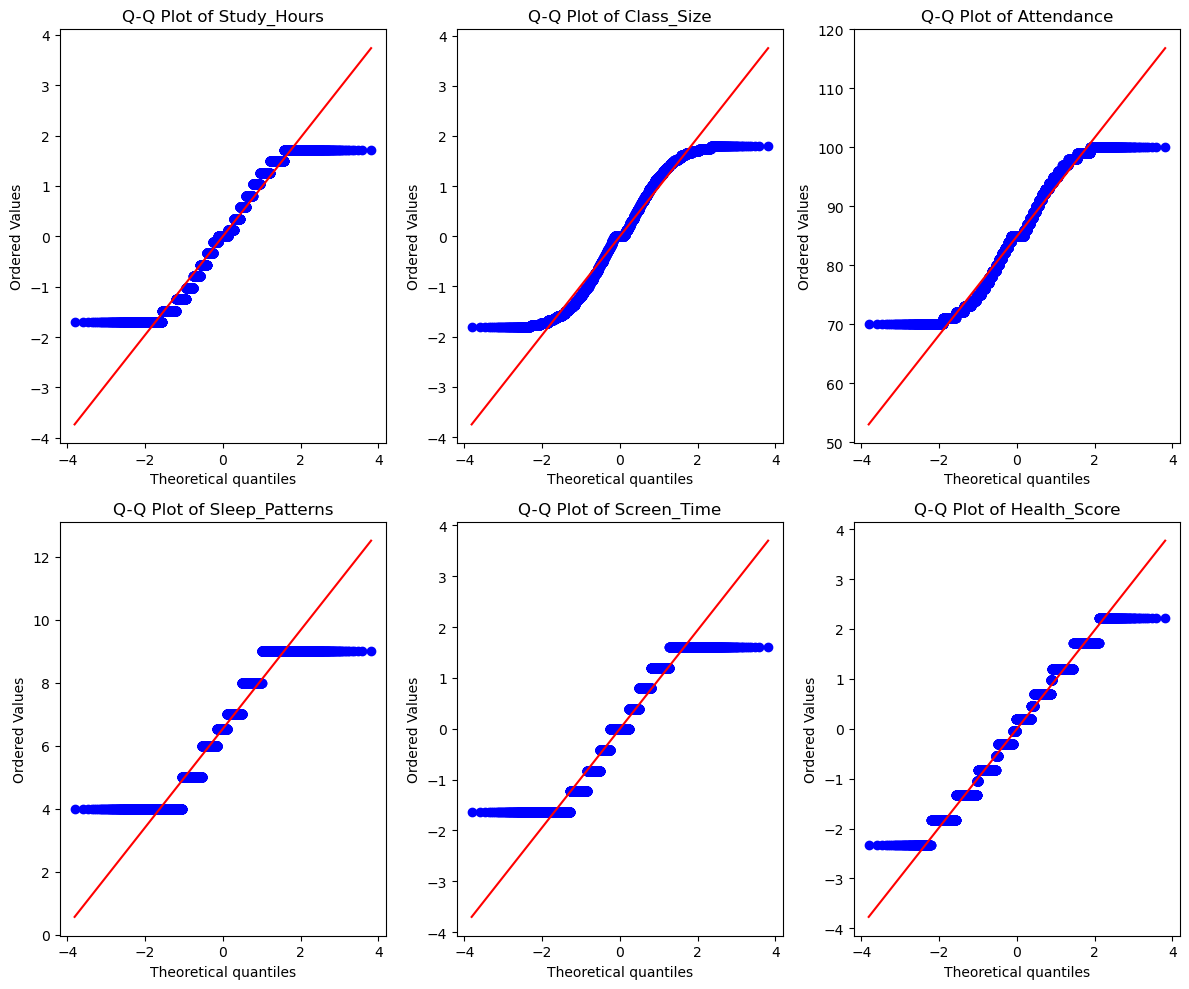

In [33]:
# --- Import Libraries ---
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import skew, probplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Load Data ---
df = pd.read_csv('students.csv')

# --- Step 1: Preprocessing ---

## 1.1: Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

## 1.2: Handle missing values
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

## 1.3: Validate missing values
print("Remaining missing values:\n", df.isnull().sum())

## 1.4: Handle skewness for numerical features
skewed_features = df[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
for col in skewed_features.index:
    if abs(skewed_features[col]) > 0.75:  # Log-transform highly skewed features
        df[col] = np.log1p(df[col])

# --- Step 2: Feature Engineering ---

## 2.1: Create composite scores
df['Health_Score'] = (
    df['Sleep_Patterns'] +
    df['Nutrition'].map({'Unhealthy': 0, 'Balanced': 1, 'Healthy': 2}) +
    df['Physical_Activity'].map({'Low': 0, 'Medium': 1, 'High': 2})
)

df['Distraction_Score'] = (
    df['Time_Wasted_on_Social_Media'] +
    df['Sports_Participation'].map({'Low': 0, 'Medium': 1, 'High': 2}) +
    df['Lack_of_Interest'].map({'Low': 0, 'Medium': 1, 'High': 2})
)

df['Support_Index'] = (
    df['Parental_Involvement'].map({'Low': 0, 'Medium': 1, 'High': 2}) +
    df['Tutoring'].map({'Yes': 1, 'No': 0}) +
    df['Mentoring'].map({'Yes': 1, 'No': 0})
)

## 2.2: Create attendance levels and normalize
df['Attendance_Level'] = pd.cut(df['Attendance'], bins=[0, 80, 95, 100], labels=['Low', 'Medium', 'High'])
df['Attendance_Level'] = df['Attendance_Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
attendance_scaler = StandardScaler()
df['Normalized_Attendance'] = attendance_scaler.fit_transform(df[['Attendance']])

## 2.3: Calculate Study Engagement
df['Study_Engagement'] = (
    df['Class_Participation'].map({'Low': 0, 'Medium': 1, 'High': 2}) +
    df['Normalized_Attendance'] +
    df['Study_Hours']
)

## 2.4: Encode Grades (if categorical)
if 'Grades' in df.columns:
    df['Grades'] = df['Grades'].map({'A': 2, 'B': 1, 'C': 0})

# --- Step 3: Scaling and Normalization ---

## 3.1: Features to scale
features_to_scale = ['Study_Hours', 'Screen_Time', 'Time_Wasted_on_Social_Media',
                     'Class_Size', 'Health_Score', 'Distraction_Score',
                     'Support_Index', 'Study_Engagement']

## 3.2: Min-max scaling
min_max_scaler = MinMaxScaler()
df[features_to_scale] = min_max_scaler.fit_transform(df[features_to_scale])

## 3.3: Standardization
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])



# --- Step 4: Exploratory Data Analysis ---

## 4.1: Check skewness of numerical features
print("\nSkewness of Numerical Features:\n", skewed_features)

## 4.2: Plot distributions of numerical features
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.show()

## 4.3: Correlation analysis
corr_features = ['Study_Hours', 'Class_Size', 'Attendance', 'Sleep_Patterns', 'Screen_Time', 'Health_Score']
corr_matrix = df[corr_features].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## 4.4: Pairplot
selected_columns = ['Grades', 'Study_Hours', 'Class_Size', 'Attendance', 'Sleep_Patterns', 'Screen_Time', 'Health_Score']
sns.pairplot(df[selected_columns], hue='Grades', palette='coolwarm')
plt.suptitle('Pairplot of Selected Features', fontsize=16)
plt.tight_layout()
plt.show()

## 4.5: Q-Q plots
plt.figure(figsize=(12, 10))
for i, feature in enumerate(corr_features, 1):
    plt.subplot(2, 3, i)
    probplot(df[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {feature}')
plt.tight_layout()
plt.show()

# --- Step 5: Save Processed Data ---
os.makedirs('./data', exist_ok=True)
df.to_csv('./data/fully_preprocessed_student_grades.csv', index=False)
